# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unidecode

# Equivalences

In [2]:
NAMES_EQUIVALENCE = {'bicepscurl': 'maquina bicepscurl',
'maquina de tira multiuso': 'maquina tira multiuso',
'mancuernas bicep': 'mancuernas biceps',
'barra bicep':'barra biceps',
'maquina del fondo': 'maquina del fondo 1',
'maquina bicep predicador': 'biceps predicador',
'barras en agarre neutro x 5': 'barras con agarre neutro x 5',
'barras agarre neutro x 5': 'barras con agarre neutro x 5',
'sentadillas con peso': 'sentadilla con peso',
'maquina tira multi uso triceps': 'maquina tira multiuso triceps',
'maquina tira multi uso': 'maquina tira multiuso',
'barra en agarre neutro x 5': 'barras con agarre neutro x 5',
'barra agarre neutro x 5': 'barras con agarre neutro x 5',
'maquina tira multiuso bicep': 'maquina tira multiuso biceps',
'mancuerna biceps': 'mancuernas biceps',
'maquina tira multiuso tricep': 'maquina tira multiuso triceps',
'mancuerna bicep': 'mancuernas biceps',
'mancuerna hombro':'mancuernas hombro',
'reno con peso': 'remo con peso',
'calentismiento medio': 'calentamiento medio',
'calentamiento': 'calentamiento medio',
'barra con agarre neutro x 5': 'barras con agarre neutro x 5',
'barras en agarre supino': 'barras con agarre supino',
'maquina tira multiuso bicep.': 'maquina tira multiuso biceps',
'maquina  bicepscurl': 'maquina bicepscurl',
'barras en agarre neutro x 6': 'barras con agarre neutro x 6',
'barra en agarre neutro x 6': 'barras con agarre neutro x 6',
'barra con agarre neutro x 6': 'barras con agarre neutro x 6',
'barra con agarre en prona x 6': 'barras con agarre prono x 6',
'barras agarre neutro x 6': 'barras con agarre neutro x 6', 
'barra 6 en subida con peso': 'barras 6 en subida con peso',
'barras con agarre neutro x6': 'barras con agarre neutro x 6',
'barra con agarre neutro x 5': 'barras con agarre neutro x 5',
'biceps con barra': 'barra biceps',
'bicep': 'biceps',
'tricep y espalda': 'espalda y triceps', 
'triceps y espalda': 'espalda y triceps'
}

# Useful functions

In [3]:
def data_by_year_range_splitter(year: int):
    training_year = ""
    flag = False
    line = "a"

    with open("Datos de entreno.txt", encoding='utf-8') as file:
        while True and line != "":
            line = file.readline()

            if line.find(str(year)) != -1:
                flag = True
            
            if line.find(str(year + 1)) != -1:
                break

            if flag:
                training_year += line

    with open(f"Datos de entreno {year}.txt", "w", encoding='utf-8') as file:
        file.write(training_year)

In [5]:
def from_brackets_extracter(line: str):
    lower_bound, upper_bound, unit = 0, 0, ""
    
    if len(re.findall(r"\[(.+),", line)) >= 1:
        lower_bound = re.findall(r"\[(.+),", line)[0] 

    if len(re.findall(r",\s?([\d\.]+)\]", line)) >= 1:
        upper_bound = re.findall(r",\s?([\d\.]+)\]", line)[0]

    if len(re.findall(r"\]([\w]+)", line)) >= 1:
        unit = re.findall(r"\]([\w]+)", line)[0]

    return float(lower_bound), float(upper_bound), unit

def intern_name_and_weight_extractor(line: str):
    name, weight, lower_bound, upper_bound, failure, unit = "", None, 0, 0, False, ""

    results = line.split("-")

    name = results[0].strip()
    
    if len(results) >= 2:
        name = results[0].strip()
        weight = results[1].strip()
        
        if line.find("[") != -1:
            lower_bound, upper_bound, unit = from_brackets_extracter(line)
            weight = (lower_bound + upper_bound) / 2

        else:
            if len(re.findall(r"-\s?([\d\.])+", line)) >= 1:
                weight = re.findall(r"-\s?([\d\.]+)", line)[0]
                unit = re.findall(r"-\s?[\d\.]+([\w]+)", line)[0]
            else:
                unit = None

    failure = line.lower().find("falla") != -1

    return name, weight, lower_bound, upper_bound, failure, unit                

In [6]:
def general_data_extractor(year):
    trainig_data = {
        "date": [],
        "exercise_day": [],
        "name": [],
        "weight": [],
        "lower_bound": [],
        "upper_bound": [],
        "failure": [],
        "unit": []
    }

    exercise_day = ""
    
    with open(f"Datos de entreno {year}.txt", "r", encoding="utf-8") as file:
        date = np.nan
        
        for line in file.readlines():
            result = re.search(r"\d{1,2}\/\d{1,2}\/" + str(year), line)

            if result:
                date = result.group()
                
                if line.find("-") != -1:
                    exercise_day = line.split("-")[1].strip()
                    
            else:
                name, weight, lower_bound, upper_bound, failure, unit = intern_name_and_weight_extractor(line)
                
                trainig_data["date"].append(date)
                trainig_data["exercise_day"].append(exercise_day)
                trainig_data["name"].append(name)
                trainig_data["weight"].append(weight)
                trainig_data["lower_bound"].append(lower_bound)
                trainig_data["upper_bound"].append(upper_bound)
                trainig_data["failure"].append(failure)
                trainig_data["unit"].append(unit)
                        
    return pd.DataFrame(trainig_data)

In [7]:
def dataframe_cleaning(dataframe: pd.DataFrame):
    partial_dataframe = dataframe[~dataframe["date"].isna()]
    final_dataframe = partial_dataframe[partial_dataframe["name"] !=""]

    return final_dataframe

In [8]:
def dtypes_transformation(dataframe: pd.DataFrame):
    dataframe["weight"] = dataframe["weight"].astype(float)
    dataframe["date"] = pd.to_datetime(dataframe["date"], dayfirst=True)

    return dataframe

In [9]:
def names_homologation(dataframe: pd.DataFrame):
    dataframe["exercise_day"] = dataframe["exercise_day"].map(lambda x: unidecode.unidecode(x.lower()))
    dataframe["name"] = dataframe["name"].map(lambda x: unidecode.unidecode(x.lower()))

    return dataframe.replace(NAMES_EQUIVALENCE)

# ETL

In [218]:
# data_by_year_range_splitter(2022)
# data_by_year_range_splitter(2023)
# data_by_year_range_splitter(2024)

In [10]:
training_df_2022 = general_data_extractor(2022)
training_df_2023 = general_data_extractor(2023)
training_df_2024 = general_data_extractor(2024)

In [11]:
final_frames = [training_df_2022, training_df_2023, training_df_2024]

partial_final_dataframe = pd.concat(final_frames)

In [12]:
partial_final_dataframe = dataframe_cleaning(partial_final_dataframe)
partial_final_dataframe = dtypes_transformation(partial_final_dataframe.copy())

In [13]:
final_df = names_homologation(partial_final_dataframe.copy())

In [14]:
final_df.sort_values(by="date")

,date,exercise_day,name,weight,lower_bound,upper_bound,failure,unit
3,2022-10-15,biceps,maquina bicepscurl,29.30,0.0,0.0,False,kg
4,2022-10-15,biceps,maquina chestpress,28.10,0.0,0.0,False,kg
5,2022-10-15,biceps,maquina shoulderpress,17.40,0.0,0.0,False,kg
6,2022-10-15,biceps,maquina tira multiuso,9.05,7.9,10.2,False,kg
7,2022-10-15,biceps,mancuernas biceps,6.00,0.0,0.0,False,kg
...,...,...,...,...,...,...,...,...
597,2024-10-29,espalda y triceps,remo con peso,43.75,40.0,47.5,False,kg
599,2024-10-29,espalda y triceps,fondos con peso,7.50,0.0,0.0,True,kg
595,2024-10-29,espalda y triceps,calentamiento medio,NaN,0.0,0.0,False,
596,2024-10-29,espalda y triceps,barras 6 en subida,7.00,0.0,0.0,False,kg


In [15]:
final_df

,date,exercise_day,name,weight,lower_bound,upper_bound,failure,unit
3,2022-10-15,biceps,maquina bicepscurl,29.30,0.0,0.0,False,kg
4,2022-10-15,biceps,maquina chestpress,28.10,0.0,0.0,False,kg
5,2022-10-15,biceps,maquina shoulderpress,17.40,0.0,0.0,False,kg
6,2022-10-15,biceps,maquina tira multiuso,9.05,7.9,10.2,False,kg
7,2022-10-15,biceps,mancuernas biceps,6.00,0.0,0.0,False,kg
...,...,...,...,...,...,...,...,...
596,2024-10-29,espalda y triceps,barras 6 en subida,7.00,0.0,0.0,False,kg
597,2024-10-29,espalda y triceps,remo con peso,43.75,40.0,47.5,False,kg
598,2024-10-29,espalda y triceps,planchas,80.00,45.0,115.0,False,s
599,2024-10-29,espalda y triceps,fondos con peso,7.50,0.0,0.0,True,kg


# Loading to database

Imports

In [36]:
from sqlalchemy import create_engine, Column, Integer, String, DateTime, Double, Boolean
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.dialects.postgresql import VARCHAR
from dotenv import load_dotenv
import os

In [39]:
Base = declarative_base()

# Define your table structure
class ExerciseData(Base):
    __tablename__ = 'exercise_data_test'
    
    id = Column(Integer, primary_key=True, autoincrement=True)  # Auto-incrementing column
    exercise_day = Column(String(30))
    name = Column(String(40))
    unit = Column(String(5))
    date = Column(DateTime)
    weight  = Column(Double())
    lower_bound = Column(Double())
    upper_bound = Column(Double())
    failure = Column(Boolean())

# Create a database engine
engine = create_engine(os.environ.get("CONN_STR"))

# Create DB session
Session = sessionmaker(bind=engine)
session = Session()

# Create the table in the database
Base.metadata.create_all(engine)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_25044\2645371688.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [40]:
load_dotenv(override=True)

engine = create_engine(os.environ.get("CONN_STR"))
final_df.to_sql(name="exercise_data_test", con=engine, index=False,
                # dtype={
                #     "exercise_day": VARCHAR(30),
                #     "name": VARCHAR(40),
                #     "unit": VARCHAR(5)
                # },
                if_exists="append",
                method="multi",
                )

1521

: 

# Obtención del peso

In [156]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import DATE
from dotenv import load_dotenv
import os

In [ ]:
content = ""
with open("Datos de entreno 2024.txt", "r", encoding="utf-8") as file:
    content = file.readlines()

['——————————2024——————————\n',
 '\n',
 '08/01/2024 - Bíceps \n',
 '\n',
 'Calentamiento medio \n',
 '\n',
 'Máquina BicepsCurl - [44.4, 47.3]kg \n',
 'Press inclinado - 20kg - falla \n',
 'Mancuernas hombro - [6, 8]kg\n',
 'Mancuernas bíceps - 10kg \n',
 'Barra bíceps - 20kg\n',
 '\n',
 '09/01/2024 - Espalda y tríceps \n',
 '\n',
 'Calentamiento medio y muscular \n',
 '\n',
 'Barras con peso 6 en subida - 2kg\n',
 'Remo con peso - [40, 47.5]kg - falla\n',
 'Fondos con peso - [8, 10]kg - más \n',
 'Barras con agarre neutro x 6\n',
 '\n',
 '13/01/2024 - pierna \n',
 '\n',
 'Calentamiento medio para pierna\n',
 '\n',
 'Máquina LegExtension - [45, 48.4]kg \n',
 'Máquina SeatedLegCurl - [32, 35.4]kg \n',
 'Máquina LegPress - [103.5, 110.3]kg \n',
 'Sentadillas con peso - [40, 47.5]kg - falla\n',
 'Máquina ProneLegCurl - [33.1, 36]kg - falla \n',
 '\n',
 '16/01/2024 - Bíceps \n',
 '\n',
 'Calentamiento medio \n',
 '\n',
 'Máquina BicepsCurl - [44.4, 47.3]kg \n',
 'Máquina ShoulderPress - [24

In [ ]:
weights = []
dates = []

for line in content:    
    if re.search(r"\d{1,2}\/\d{1,2}\/\d{4}", line):
        split_line = line.split("-")

        if len(split_line) >= 3:
            dates.append(split_line[0])
            weights.append(split_line[2].replace("\n", ""))

In [62]:
results = pd.DataFrame({
    "date": dates,
    "weight": weights,
})

In [63]:
final_results = results.replace(" ", np.nan).dropna()

In [66]:
final_results["date"].unique()

array(['14/05/2024 ', '27/05/2024 ', '30/05/2024 ', '11/06/2024 ',
       '12/06/2024 ', '19/06/2024 ', '20/06/2024 ', '21/06/2024 ',
       '24/06/2024 ', '26/06/2024 ', '01/07/2024 ', '04/07/2024 ',
       '09/07/2024 ', '18/07/2024 ', '25/07/2024 ', '08/08/2024 ',
       '09/08/2024 ', '20/08/2024 ', '23/08/2024 ', '27/08/2024 ',
       '01/09/2024 ', '05/09/2024 ', '06/09/2024 ', '08/09/2024 ',
       '10/09/2024 ', '12/09/2024 ', '15/09/2024 ', '17/09/2024 ',
       '19/09/2024 ', '20/09/2024 ', '01/10/2024 ', '03/10/2024 ',
       '08/10/2024 ', '10/10/2024 ', '22/10/2024 ', '23/10/2024 ',
       '25/10/2024 ', '29/10/2024 '], dtype=object)

In [67]:
final_results["date"] = pd.to_datetime(final_results["date"], format="%d/%m/%Y ")

In [77]:
final_results["weight"] = final_results["weight"].str.replace("kg", "").astype(float)

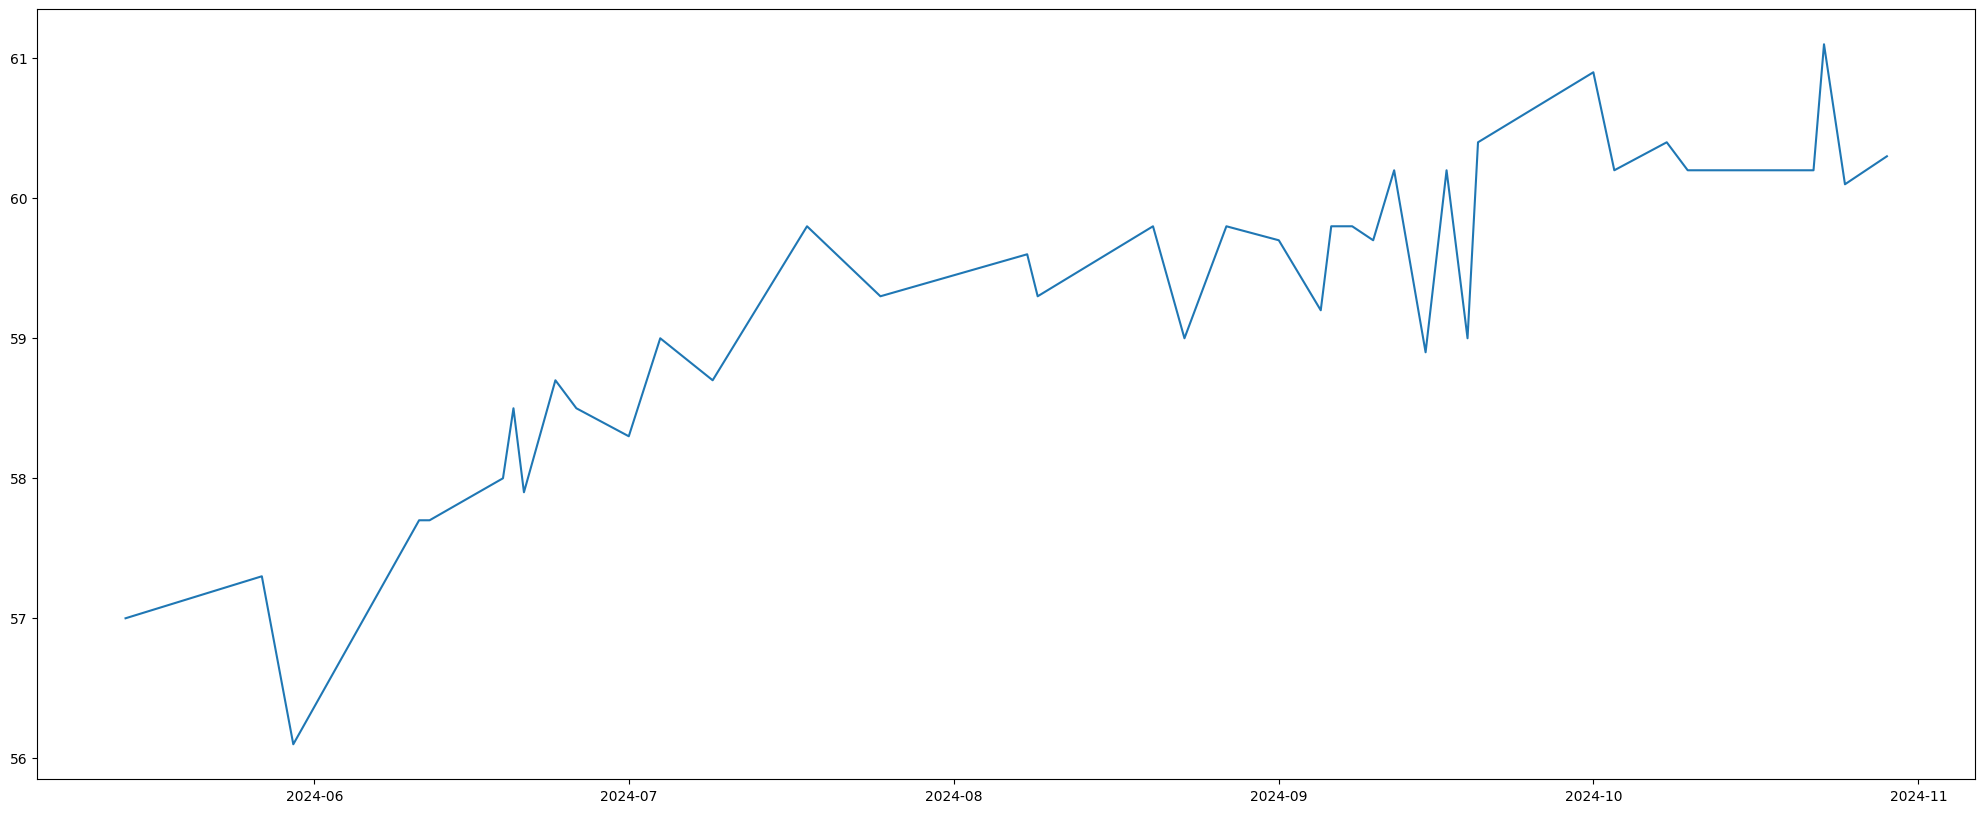

In [78]:
plt.figure(figsize=(25, 10))
plt.plot(final_results["date"], final_results["weight"])

In [158]:
load_dotenv(override=True)

engine = create_engine(os.environ.get("CONN_STR"))
final_results.to_sql(name="weight_data", con=engine, index=False,
                dtype={
                    "date": DATE(),
                },
                if_exists="replace",
                method="multi"
                )

38